# **Content**

<br>

### [1. Libraries Import](#import) ##
### [2. Read images and Data exploration](#makedf) ## 
### [3. Resampling](#trim) ##
### [4. Train, test and validation](#generators) ## 
### [5. Training sample visualization](#show) ## 
### [6. Machine Learning Model](#model) ## 
### [7. Custom Keras callback](#callback) ## 
### [8. Instantiate callback](#callbacks) ##
### [9. Model training](#train) ##
### [10. Plotting](#plot) ##
### [11. Prediction and Accuracy assessment](#result) ##
### [12. Model Export](#save) ##

***

<a id="import"></a>
# <center>Import Libraries</center>

In [8]:
# data analysis library
import numpy as np
import pandas as pd
import os
import math
import time
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# plotting and image analysis library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
sns.set_style('darkgrid')

# machine learning library
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

tf.random.set_seed(1234)
from numpy.random import seed
seed(42)

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

<a id="makedf"></a>
# <center>Data Import and Exploration</center>

#### First, we will import our data and do some EDA to understand our data.

In [9]:
pwd

'/kaggle/working'

In [10]:
train_path=r'../input/paddy-disease-classification/train_images'
test_path=r'../input/paddy-disease-classification/test_images'

# read in train.csv
df=pd.read_csv(r'../input/paddy-disease-classification/train.csv')
df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [11]:
df.count()

image_id    10407
label       10407
variety     10407
age         10407
dtype: int64

#### Looking at the metadata.

In [12]:
for col in df[['age','variety']]:
    print(df[col].unique())

[45 50 55 60 65 68 70 72 47 77 67 73 75 80 62 66 57 82]
['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']


#### Let's draw 9 samples for plotting.

In [15]:
all_sample = {}

for category in df['label'].unique():
    shuffle = df.sample(frac=1).reset_index(drop=True)
    imgs = shuffle[shuffle['label'] == category].values
    sample = imgs[0:9]
    all_sample[category] = sample

#### Write a function to plot images from each categories.

In [16]:
def plot_category(name, f_dict=all_sample):
    """
    plot example images
    """
    assert isinstance(name, str), "name must be a string!"
    
    fig, axes = plt.subplots(3,3, figsize=(15, 15))
    fig.suptitle(name, fontsize=24)
    
    try:
        arr = f_dict[name]
    except KeyError as e:
        print("Category not exist!")
        print(e)
        
    f_names = [f[0] for f in arr]
    f_var = [f[2] for f in arr]
    f_age = [f[3] for f in arr]

    for n, filename in enumerate(f_names):
        f = os.path.join(train_path, name, filename)
        img = mpimg.imread(f)
        ax = plt.subplot(3, 3, n + 1)
        ax.imshow(img)
        ax.set_title("{} in {} days".format(f_var[n], f_age[n]))
        ax.axis('off')

    plt.tight_layout()

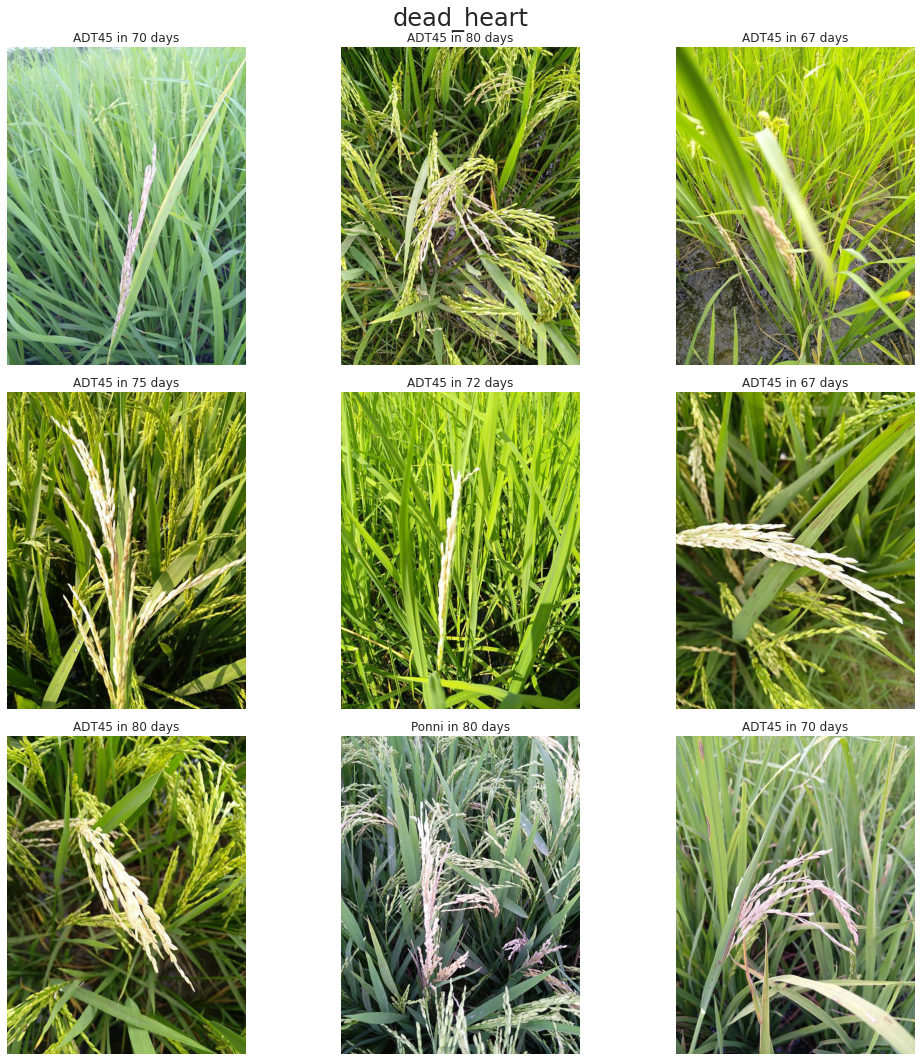

In [17]:
plot_category("dead_heart")

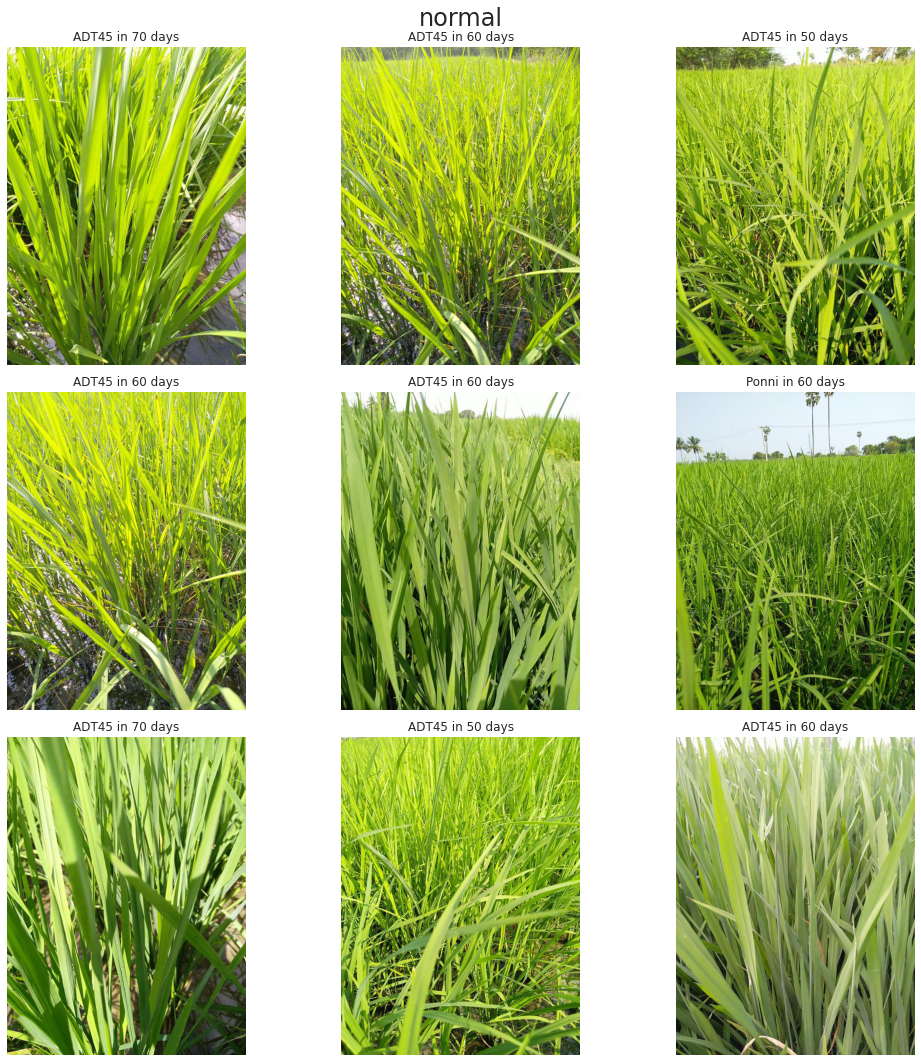

In [18]:
plot_category("normal")

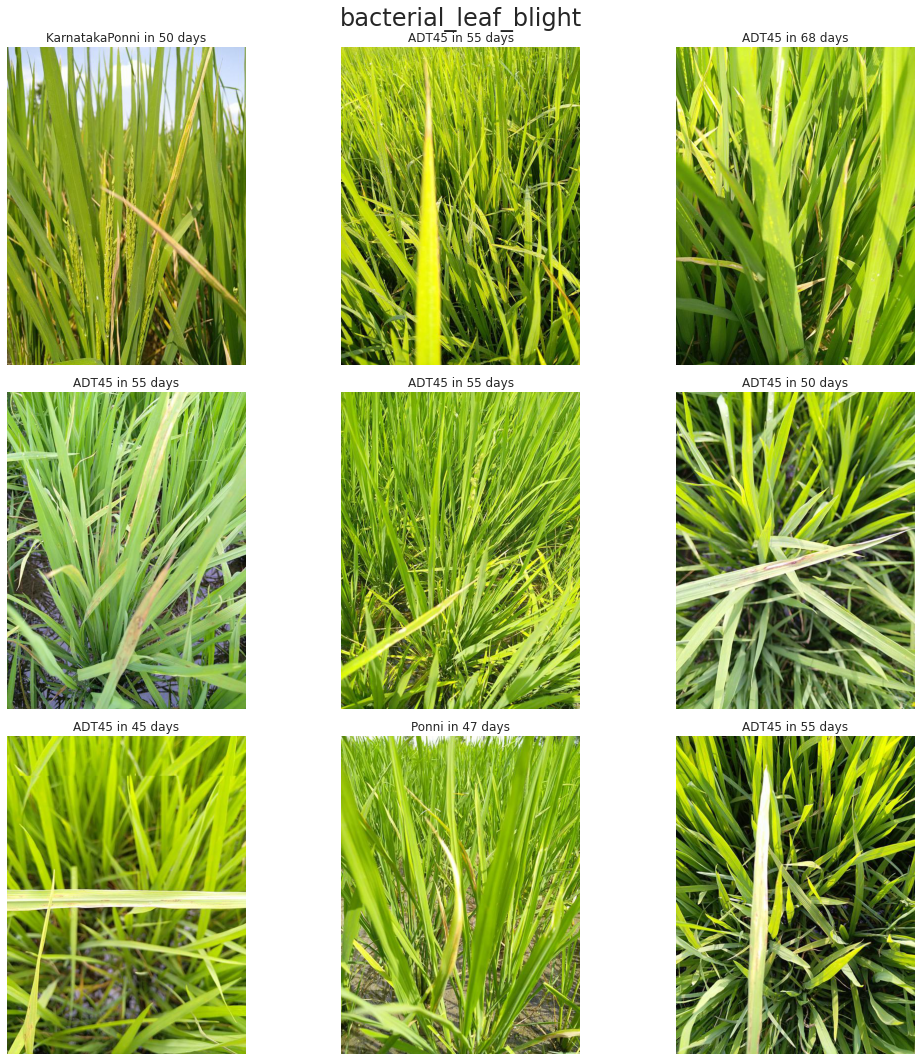

In [19]:
plot_category("bacterial_leaf_blight")

<a id="resample"></a>
# <center>Data Resampling</center>

#### To resolve class imbalance, we will oversample each group followed by data argumentation. Let's write a sample for it.

In [20]:
def oversample(df, col='label', n=1500):
    """
    oversample each label to resolved imbalanced classes
    """
    for count, i in enumerate(df[col].unique()):
        df_class = df[df[col] == i]
        df_class_resample = df_class.sample(n, replace=True)
        if count == 0:
            df_resample = df_class_resample
        else:
            df_resample = pd.concat([df_class_resample, df_resample], axis=0)

    return df_resample

In [21]:
df_resample = oversample(df)
df = None
gc.collect()

60841

In [22]:
df_resample.head()

image_id   label variety  age
9473   101390.jpg  tungro   ADT45   60
9610   105799.jpg  tungro   ADT45   60
10220  104234.jpg  tungro   ADT45   72
10240  105430.jpg  tungro   ADT45   72
9394   109497.jpg  tungro   ADT45   45

#### Now, we have 1500 images for each group.

In [23]:
print(df_resample.label.value_counts())

tungro                      1500
normal                      1500
hispa                       1500
downy_mildew                1500
dead_heart                  1500
brown_spot                  1500
blast                       1500
bacterial_panicle_blight    1500
bacterial_leaf_streak       1500
bacterial_leaf_blight       1500
Name: label, dtype: int64


<a id="split"></a>
# <center>Data Split: Training and Validation</center>

#### Let's write a function for splitting training and validation data into custom ratio 9:1.

In [24]:
def create_train_valid(df, train_path, train_size=.9, shuffle=True, random_state=123):
    """
    create file path and split data
    """
    if not 'label' in df.columns:
        print("label not found!")
        raise
        
    if not 'image_id' in df.columns:
        print("image_id not found!")
        raise
    
    df['filepaths'] = df[['label','image_id']].apply(lambda row: os.path.join(train_path, *row), axis=1)
    df_new = df[['filepaths','label']]
    df_new = df_new.rename(columns={"label": "labels"})

    train_df, valid_df = train_test_split(
        df_new, 
        train_size=train_size, 
        shuffle=shuffle, 
        random_state=random_state, 
        stratify=df_new['labels'])

    return train_df, valid_df

In [25]:
train_df, valid_df = create_train_valid(df_resample, train_path)
print('train_df length: ', len(train_df), '\nvalid_df length: ', len(valid_df))

gc.collect()

train_df length:  13500 
valid_df length:  1500


23

In [26]:
train_df = train_df.reset_index()[['filepaths','labels']]
train_df.head()

filepaths                    labels
0  ../input/paddy-disease-classification/train_im...  bacterial_panicle_blight
1  ../input/paddy-disease-classification/train_im...  bacterial_panicle_blight
2  ../input/paddy-disease-classification/train_im...                     hispa
3  ../input/paddy-disease-classification/train_im...  bacterial_panicle_blight
4  ../input/paddy-disease-classification/train_im...                dead_heart

#### Checking image data statistics.

In [27]:
def get_stats(df, n=100, random_state=123):
    """
    check training image statistics
    """
    if not 'filepaths' in df.columns:
        print("filepaths not found!")
        raise
        
    ht = []
    wt = []
    sample = df.sample(n=n, random_state=random_state, axis=0)

    for i in range(n):
        fpath = sample['filepaths'].iloc[i]
        img = plt.imread(fpath)
        ht.append(img.shape[0])
        wt.append(img.shape[1])

    avg_h = np.mean(np.array(ht))
    avg_w = np.mean(np.array(wt))
    aspect = round(avg_h/avg_w,2)
    
    return avg_h,  avg_w, aspect

In [28]:
avg_h, avg_w, aspect = get_stats(train_df)
print('average height= ', avg_h, '\naverage width= ', avg_w, '\naspect= ', aspect)

average height=  638.4 
average width=  481.6 
aspect=  1.33


<a id="test"></a>
# <center>Import Test Data</center>

In [29]:
submit_df=pd.read_csv(r'../input/paddy-disease-classification/sample_submission.csv')
test_df = submit_df
test_df=test_df.drop('label', axis=1)
test_df.columns=['filepaths']
test_df['filepaths']=test_df['filepaths'].apply(lambda x: os.path.join(test_path,x))

<a id="generators"></a>
# <center>Create train_gen, test_gen and valid_gen with Data Argumentation</center>

#### Then, we will do some data argumentation, adjusting brightness, color, and other attributes of the original data.

In [ ]:
from random import choice

def custom_augmentation(np_tensor):
    """
    training data argumentation
    """
    aug_choice = np.random.randint(2, size=10)
    
    def cutout(np_tensor):
        """
        cutting out part of the image
        """
        cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
        cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])
        cutout_height_point = np.random.randint(np_tensor.shape[0]-cutout_height)
        cutout_width_point = np.random.randint(np_tensor.shape[1]-cutout_width)
        np_tensor[cutout_height_point:cutout_height_point+cutout_height, cutout_width_point:cutout_width_point+cutout_width, :] = 127
        return np_tensor

    def gaussian_noise(np_tensor):
        """
        add gaussian noise
        """
        mean = 0
        # variance: randomly between 1 to 25
        var = np.random.randint(1, 26)
        # sigma is square root of the variance value
        noise = np.random.normal(mean,var**0.5,np_tensor.shape)
        return np.clip(np_tensor + noise, 0, 255).astype('int')
    
    def random_crop(np_tensor):
        """
        cropping the images in random sizes
        """
        # cropped height between 70% to 130%
        new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
        # cropped width between 70% to 130%
        new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
        # resize to new height and width
        cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
        return tf.image.resize(cropped, np_tensor.shape[:2])
    
    def random_contrast(np_tensor):
        """
        adjusting the contrast
        """
        return tf.image.random_contrast(np_tensor, 0.5, 2)
 
    def random_hue(np_tensor):
        """
        adjusting hue
        """
        return tf.image.random_hue(np_tensor, 0.5)
 
    def random_saturation(np_tensor):
        """
        adjusting saturation
        """
        return tf.image.random_saturation(np_tensor, 0.2, 3)
    
    # apply two argumentation methods randomly
    fns = [random_crop, gaussian_noise, cutout, random_contrast, random_hue, random_saturation]
    augmnted_tensor = choice(fns)(np_tensor)
    augmnted_tensor = choice(fns)(augmnted_tensor)
    
    return np.array(augmnted_tensor)

#### Generate training, validation, and testing data.

In [30]:
# training generator with data argumentation
trgen=ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=30, 
    width_shift_range=.2,
    height_shift_range=.2,
    fill_mode="wrap",
    shear_range=.2,
    brightness_range=(.5, 1.5),
    zoom_range=.4,
    channel_shift_range=30,
    #rescale=1./255,
    #preprocessing_function=custom_augmentation
)

# testing and validation generator with data argumentation
t_and_v_gen=ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(.7, 1.5),
    fill_mode="wrap",
    zoom_range=.2
)

In [31]:
working_dir=r'./'
img_size=(320,240)
batch_size=20 # for EfficientetB3 model

msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')

train_gen=trgen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')

valid_gen=t_and_v_gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size,
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

Found 13500 validated image filenames belonging to 10 classes.         for train generator 
Found 1500 validated image filenames belonging to 10 classes.          for valid generator 


In [32]:
test_df.head().values

array([['../input/paddy-disease-classification/test_images/200001.jpg'],
       ['../input/paddy-disease-classification/test_images/200002.jpg'],
       ['../input/paddy-disease-classification/test_images/200003.jpg'],
       ['../input/paddy-disease-classification/test_images/200004.jpg'],
       ['../input/paddy-disease-classification/test_images/200005.jpg']],
      dtype=object)

In [33]:
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.

test_batch_size=10
test_steps=int(len(test_df)/test_batch_size)

msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

test_gen=t_and_v_gen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col=None, 
    target_size=img_size,
    class_mode=None, 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)

# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)

print('\ntest batch size: {}\ntest steps: {}\nnumber of classes: {}'.format(test_batch_size, test_steps, class_count))

Found 3469 validated image filenames.                                  for test generator 

test batch size: 10
test steps: 346
number of classes: 10


<a id="show"></a>
# <center>Data Exploration before Training</center>

In [34]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    
    plt.figure(figsize=(20, 20))
    r=len(labels) if len(labels)<25 else 25

    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        
        index=np.argmax(labels[i])
        class_name=classes[index]
        
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
        
    plt.show()

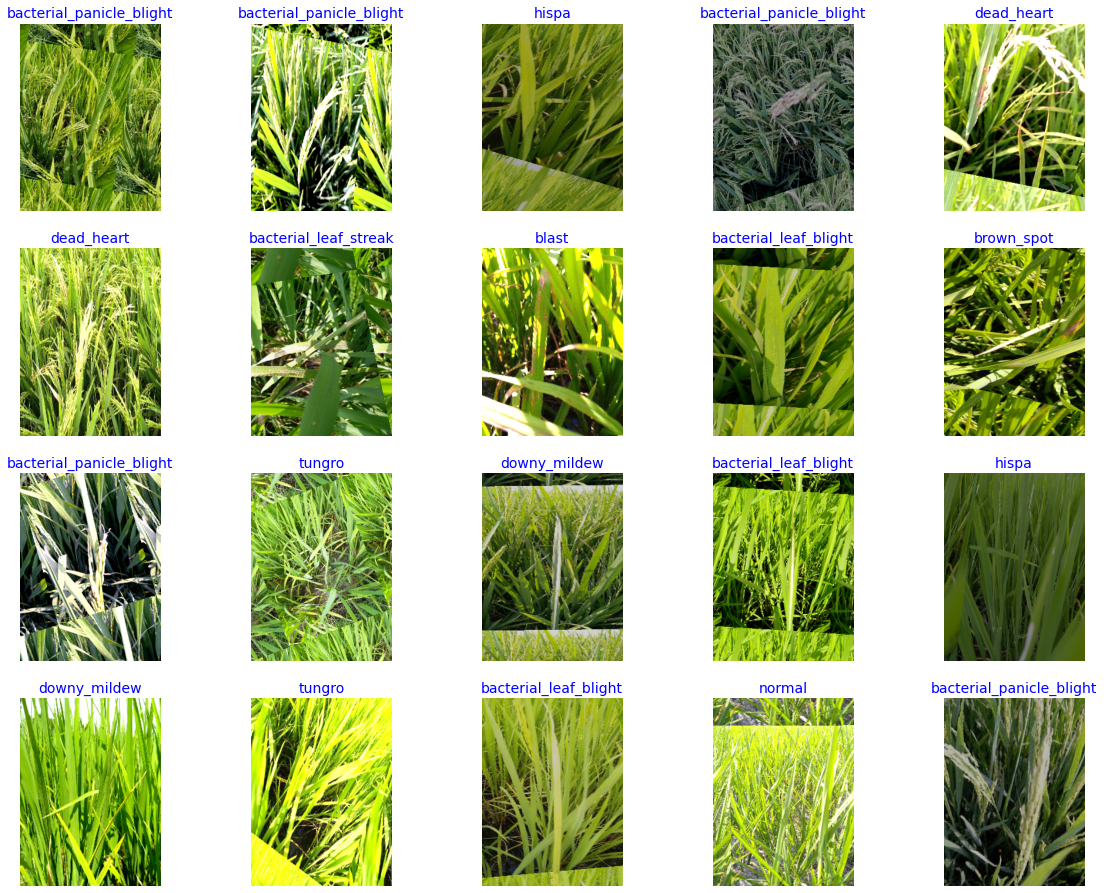

In [35]:
show_image_samples(train_gen)

<a id="model"></a>
# <center>Transfer Learning with EfficientNetB3</center>

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
# model_name='EfficientNetB3'
    
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, 
    weights="imagenet",
    input_shape=img_shape, 
    pooling='max')

# Note you are always told NOT to make the base model trainable initially but you get better results leaving it trainable
base_model.trainable = True
x = base_model.output

# x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

x = BatchNormalization(
    axis=-1, 
    momentum=0.99, 
    epsilon=0.001)(x)

x = Dense(
    256, kernel_regularizer=regularizers.l2(0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation='relu')(x)

x = Dropout(rate=.4, seed=123)(x, training=False)

# x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

lr = .001 # initiate learning rate
opt = Adamax(learning_rate=lr)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["sparse_categorical_accuracy"])#['accuracy'])

<a id="callback"></a>
# <center>Custom Keras callback</center>

The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.  
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [ ]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch):
        """
        initialize callback
        """
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # query on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None):
        """
        query ask_epoch when training begins
        """
        if self.ask_epoch == 0:  # adjust ask epoch
            print('ask_epoch set to 1 instead', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # continue training
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query
        if self.epochs == 1:
            self.ask=False
        else:
            print('Training will proceed until epoch', ask_epoch) 
            print('You can then halt training or continue training')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):
        """
        measure training time when training completed
        """
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):
        """
        update validation loss and query again at the end of epoch
        """
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # query the user
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nMaximum epochs specified as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [ ]:
# instantiate custom callback

epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)

callbacks=[ask]

<a id="summary"></a>
# <center>Model Summary</center>

In [ ]:
model.summary()

<a id="train"></a>
# <center>Model Training</center>

In [ ]:
history=model.fit(x=train_gen, epochs=epochs, verbose=True, callbacks=callbacks, validation_data=valid_gen, validation_steps=None, shuffle=False, initial_epoch=0)

# Epoch 15/40
# 675/675 [==============================] - 476s 705ms/step - loss: 0.2113 - accuracy: 0.9819 - val_loss: 0.1868 - val_accuracy: 0.9873

#  validation loss of  0.1868 is below lowest loss, saving weights from epoch 15  as best weights

<a id="train"></a>
# <center>Evaluate the model</center>

In [ ]:
# get loss and accuracy
eval_dict = model.evaluate(x=train_gen, return_dict=True)
print(*eval_dict.items(), sep='\n')

# 675/675 [==============================] - 347s 514ms/step - loss: 0.1571 - accuracy: 0.9935
# ('loss', 0.15708895027637482)
# ('accuracy', 0.993481457233429)

In [ ]:
# get loss and accuracy
eval_dict_valid = model.evaluate(x=valid_gen, return_dict=True)
print(*eval_dict_valid.items(), sep='\n')

# 75/75 [==============================] - 36s 479ms/step - loss: 0.1883 - accuracy: 0.9873
# ('loss', 0.18831852078437805)
# ('accuracy', 0.987333357334137)

<a id="test_model"></a>
# <center>Check results from trained model</center>

In [ ]:
def test_model(ds, model, max_sample=5):
    """
    display model prediction results
    """
    #imgs = np.array(ds.filenames)
    #label = np.array(ds.labels)
    
    n = max_sample
    categories = np.array(list(ds.class_indices.keys()))
    
    # display prediction examples in loop
    for i in range(0,n):
        imgs,labels = next(ds)
        preds = model.predict(ds)
        pred = preds[i]
        #pred = model.predict(imgs[i])[0]
        p = np.max(pred)*100
        pred_cat = categories[np.argmax(pred)]
        true_cat = categories[ds.labels[i]]
        print("Pred: {0:.2f}% {1:s}\nTarget: {2:s}".format(p, pred_cat, true_cat))
        #plt.imshow(np.array(imgs[i][0], dtype=np.int32))
        
        image=imgs[0]/255
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        time.sleep(3)

In [ ]:
test_model(valid_gen, model)

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = valid_gen.classes

predictions = model.predict(valid_gen)
y_pred = np.array([np.argmax(x) for x in predictions])

cm = confusion_matrix(y_true, y_pred)
cm

In [ ]:
len(valid_gen.classes)

In [ ]:
valid_gen.class_indices

<a id="plot"></a>
# <center>Visualize training performance</center>

In [ ]:
def tr_plot(tr_data):
    """
    Plot training and validation data
    """
    # get info from model
    tacc=np.array(tr_data.history['accuracy'])
    tloss=np.array(tr_data.history['loss'])
    vacc=np.array(tr_data.history['val_accuracy'])
    vloss=np.array(tr_data.history['val_loss']) 
    
    # compute statistics
    val_lowest, index_loss = np.min(vloss), np.argmin(vloss)+1
    acc_highest, index_acc = np.max(vacc), np.argmax(vacc)+1
    
    # prepare plotting data and labels
    sc_label='best epoch= {}'.format(index_loss+1)
    vc_label='highest acc= {}%'.format(round(acc_highest*100,1))
    Epochs=np.linspace(1,len(tacc),len(tacc))

    with plt.style.context('ggplot'): # define plotting style
        fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
        
        # plot Training and Validation Loss
        ax0.plot(Epochs,tloss, 'r', label='Training loss', linewidth=2, alpha=.8)
        ax0.plot(Epochs,vloss,'g',label='Validation loss', linewidth=2, alpha=.8)
        ax0.scatter(index_loss,val_lowest, s=260, c='blue', label=sc_label, marker=(5, 1))
        ax0.set_title('Training and Validation Loss', fontsize=22)
        ax0.set_xlabel('Epochs', fontsize=18)
        ax0.set_ylabel('Loss', fontsize=18)
        ax0.legend()
        
        # plot Training and Validation Accuracy
        ax1.plot (Epochs,tacc,'r',label='Training Accuracy', linewidth=2, alpha=.8)
        ax1.plot (Epochs,vacc,'g',label='Validation Accuracy', linewidth=2, alpha=.8)
        ax1.scatter(index_acc,acc_highest, s=260, c='blue', label=vc_label, marker=(5, 1))
        ax1.set_title('Training and Validation Accuracy', fontsize=22)
        ax1.set_xlabel('Epochs', fontsize=18)
        ax1.set_ylabel('Accuracy', fontsize=18)
        ax1.legend()
        
        # general layout
        ax0.grid(True, which='both', alpha=.3, c="gray")
        ax0.minorticks_on()
        
        ax1.grid(True, which='both', alpha=.3, c="gray")
        ax1.minorticks_on()
        
        plt.tight_layout()
        plt.show()

In [ ]:
tr_plot(history)

<a id="report"></a>
# <center>Classification Report</center>

In [ ]:
def plot_confusion_matrix(data, labels, filename, save=False):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    sns.set(font_scale=1.4)
    
    plt.figure(1, figsize=(9, 6))
    plt.title("Confusion Matrix")
 
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    if save == True:
        plt.savefig(filename, bbox_inches='tight', dpi=300)

# create confusion matrix
plot_confusion_matrix(cm, classes, "confusion_matrix.png")

<a id="result"></a>
# <center>Prediction on the Testing Data</a>

#### Define a function which generates predictions on the test set from a test generator

In [ ]:
# {'bacterial_leaf_blight': 0,
#  'bacterial_leaf_streak': 1,
#  'bacterial_panicle_blight': 2,
#  'blast': 3,
#  'brown_spot': 4,
#  'dead_heart': 5,
#  'downy_mildew': 6,
#  'hispa': 7,
#  'normal': 8,
#  'tungro': 9}

In [ ]:
def predictor(model, data, cat, batch_size=10, write_csv=False, verbose=True):
    """
    use model to predict image class
    """
    
    if verbose:
        preds = model.predict(data, verbose=1, batch_size=batch_size)
        count = len(cat)
        print("Predict images to {} classes.".format(count))
        print(cat)
    else:
        preds = model.predict(data, verbose=0, batch_size=batch_size)
    
    label = []
    image_id = data.filenames
    
    for i in range(preds.shape[0]):
        idx = np.argmax(preds[i])
        pred = classes[idx]
        label.append(pred)
    
    if verbose == 1:
        print("Completed {} predictions.".format(i+1))
    
    try:
        Idseries = pd.Series(image_id, name='image_id')
        Lseries = pd.Series(label, name='label')
        df = pd.concat([Idseries,Lseries], axis=1)
    except:
        print("Dataframe creation failed!")
        raise
    
    if write_csv == True:
        csv_path=os.path.join(working_dir, 'submit.csv')
        df.to_csv(csv_path, index=False)
        if verbose == 1:
            print("CSV file successfully exported!")
    
    return df

# machine learning model prediction
classes = list(train_gen.class_indices.keys())

df = predictor(model=model, data=test_gen, cat=classes)
df.head()

In [ ]:
np.unique(df.label.values == np.array(result))

In [ ]:
np.where(df.label.values != np.array(result))

In [ ]:
preds = model.predict(test_gen, verbose=1, batch_size=20)#10)

result = []
for i in range(preds.shape[0]):
    id = np.argmax(preds[i])
    pred = classes[id]
    result.append(pred)

In [ ]:
preds = model.predict(test_gen, verbose=1, batch_size=batch_size)

label = []
image_id = test_gen.filenames
    
for i in range(preds.shape[0]):
    idx = np.argmax(preds[i])
    pred = classes[idx]
    label.append(pred)

In [ ]:
np.where(np.array(label) != result)

In [ ]:
pred_1 = model.predict(test_gen, verbose=1, batch_size=batch_size)

pred_2 = model.predict(test_gen, verbose=1, batch_size=batch_size)

print(np.array_equal(pred_1, pred_2))

In [ ]:
print(df.label.values[:10])
print(result[:10])

In [ ]:
preds = model.predict(test_gen, verbose=1, batch_size=10)
preds

In [ ]:
preds.shape

In [ ]:
result = []
for i in range(preds.shape[0]):
    id = np.argmax(preds[i])
    pred = classes[id]
    result.append(pred)

result

In [ ]:
submit = pd.read_csv("submit.csv")
submit.head(10)

In [ ]:
submit['label'] = result
submit.head(10)

In [ ]:
submit.to_csv("submit_fix", index=False)

<a id="save"></a>
# <center>Save the model

In [ ]:
# loading saved model
#loaded_model = keras.models.load_model("../input/paddy-model/paddy_disease_model_v2.h5")

model_new = tf.keras.models.model_from_json(model_json)
model_new.compile()
model_new.load_weights()

In [ ]:
# check working dir
pwd

In [ ]:
# list files
ls